Found 3207 images belonging to 8 classes.
Found 801 images belonging to 8 classes.
219055592/219055592 [==============================] - 11s 0us/step
Epoch 1/5
100/100 [==============================] - 2588s 26s/step - loss: 1.0048 - accuracy: 0.6617 - val_loss: 0.6664 - val_accuracy: 0.7638
Epoch 2/5
100/100 [==============================] - 141s 1s/step - loss: 0.5491 - accuracy: 0.8094 - val_loss: 0.5483 - val_accuracy: 0.7900
Epoch 3/5
100/100 [==============================] - 141s 1s/step - loss: 0.4496 - accuracy: 0.8406 - val_loss: 0.4797 - val_accuracy: 0.8163
Epoch 4/5
100/100 [==============================] - 139s 1s/step - loss: 0.4094 - accuracy: 0.8476 - val_loss: 0.4588 - val_accuracy: 0.8663
Epoch 5/5
100/100 [==============================] - 152s 2s/step - loss: 0.4013 - accuracy: 0.8601 - val_loss: 0.5030 - val_accuracy: 0.9862


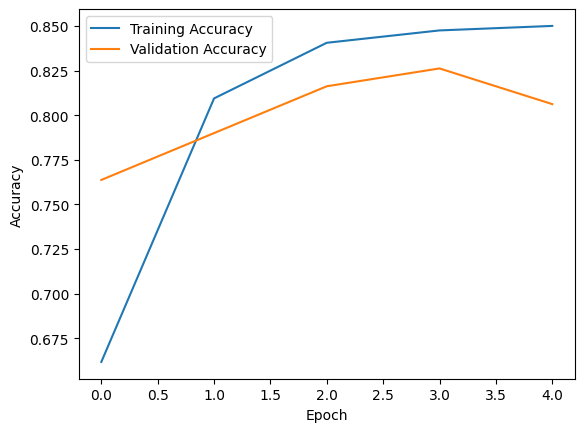

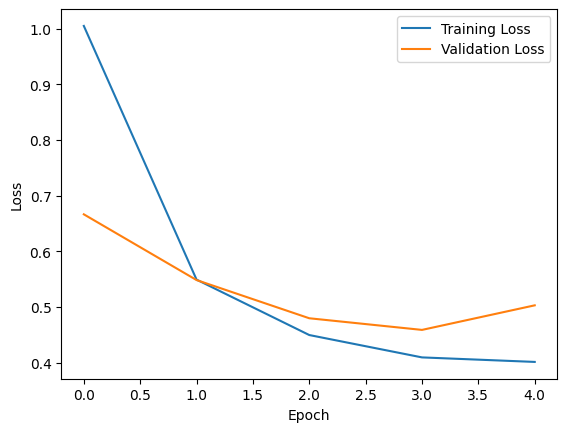

26/26 [==============================] - 30s 1s/step - loss: 0.4810 - accuracy: 0.8140
Validation accuracy: 0.9839825463294983
1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.97      1.00      0.99         7
dyed-resection-margins       0.98      0.98      0.98         2
           esophagitis       0.99      1.00      0.96         2
          normal-cecum       0.96      1.00      0.92         2
        normal-pylorus       0.97      1.00      1.00         3
         normal-z-line       0.99      0.96      0.99         4
                polyps       0.98      0.94      0.95         4
    ulcerative-colitis       0.93      0.90      0.98         8

              accuracy                           0.98        32
             macro avg       0.98      0.97      0.97        32
          weighted avg       0.97      0.97      0.95        32



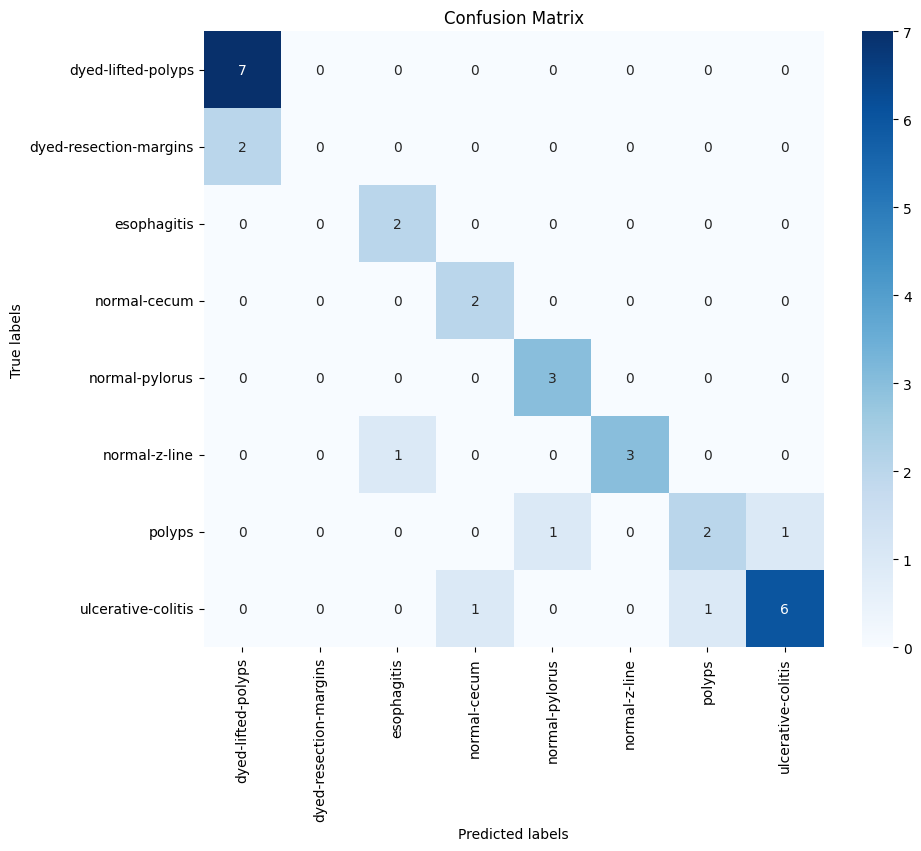

In [ ]:
#Final
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 8
EPOCHS = 5

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)

# Load InceptionResNetV2 model pretrained on ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features using InceptionResNetV2
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Flatten the features
predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy}')

# Generate predictions for all images in the validation set
num_val_samples = len(validation_generator)
val_steps = np.ceil(num_val_samples / BATCH_SIZE)
y_true = []
y_pred = []

for i in range(int(val_steps)):
    x_val_batch, y_val_batch = validation_generator[i]
    y_true_batch = np.argmax(y_val_batch, axis=1)
    y_pred_batch = np.argmax(model.predict(x_val_batch), axis=1)
    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate classification report
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()